In [ ]:
# Run this cell first in Google Colab
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
!pip install datasets


In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
# sentences = dataset["train"]["text"]

# # clean empty lines
# sentences = [s.lower() for s in sentences if len(s.split()) > 5]
# sentences = sentences[:3000]  # limit for Colab

# print("Total sentences:", len(sentences))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total sentences: 3000


In [ ]:
sentences = [
    "nepal is a landlocked country in south asia",
    "kathmandu is the capital city of nepal",
    "nepal has rich cultural heritage",
    "mount everest is the highest mountain",
    "tourism is important for nepal economy",
    "artificial intelligence enables machines to learn",
    "machine learning is a subset of artificial intelligence",
    "deep learning uses neural networks",
    "transformers use self attention mechanism",
    "bert is based on transformer architecture",
] * 30   # ~300 sentences


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
PAD, CLS, SEP, MASK = "[PAD]", "[CLS]", "[SEP]", "[MASK]"

def build_vocab(sentences):
    counter = Counter()
    for s in sentences:
        counter.update(s.split())

    vocab = {PAD:0, CLS:1, SEP:2, MASK:3}
    for w in counter:
        vocab[w] = len(vocab)

    inv_vocab = {v:k for k,v in vocab.items()}
    return vocab, inv_vocab

vocab, inv_vocab = build_vocab(sentences)
vocab_size = len(vocab)

MAX_LEN = 16

def encode(sentence):
    ids = [vocab[CLS]] + [vocab[w] for w in sentence.split()] + [vocab[SEP]]
    ids += [vocab[PAD]] * (MAX_LEN - len(ids))
    return ids[:MAX_LEN]

encoded_data = torch.tensor([encode(s) for s in sentences]).to(device)


In [ ]:
def mask_tokens(inputs):
    labels = inputs.clone()

    for i in range(inputs.size(0)):
        for j in range(inputs.size(1)):
            if inputs[i,j] in [vocab[PAD], vocab[CLS], vocab[SEP]]:
                labels[i,j] = -100
                continue

            if random.random() < 0.15:
                prob = random.random()
                if prob < 0.8:
                    inputs[i,j] = vocab[MASK]
                elif prob < 0.9:
                    inputs[i,j] = random.randint(4, vocab_size-1)
            else:
                labels[i,j] = -100
    return inputs, labels


In [ ]:
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embed_size)
        self.position = nn.Embedding(MAX_LEN, embed_size)
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x):
        pos = torch.arange(0, x.size(1)).unsqueeze(0).to(x.device)
        return self.norm(self.token(x) + self.position(pos))


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size*4),
            nn.GELU(),
            nn.Linear(embed_size*4, embed_size)
        )

    def forward(self, x):
        attn, _ = self.attn(x, x, x)
        x = self.norm1(x + attn)
        ff = self.ff(x)
        return self.norm2(x + ff)


In [ ]:
class BERT(nn.Module):
    def __init__(self, vocab_size, embed_size=128, layers=4, heads=4):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, embed_size)
        self.encoder = nn.ModuleList(
            [TransformerBlock(embed_size, heads) for _ in range(layers)]
        )
        self.mlm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1,0,2)
        for layer in self.encoder:
            x = layer(x)
        x = x.permute(1,0,2)
        return self.mlm_head(x)


In [ ]:
model = BERT(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


In [ ]:
EPOCHS = 20
train_losses = []

for epoch in range(EPOCHS):
    model.train()

    inputs, labels = mask_tokens(encoded_data.clone())
    outputs = model(inputs)

    loss = criterion(
        outputs.view(-1, vocab_size),
        labels.view(-1)
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f}")


Epoch 01 | Loss: 4.1172
Epoch 02 | Loss: 3.9777
Epoch 03 | Loss: 3.7974
Epoch 04 | Loss: 3.6222
Epoch 05 | Loss: 3.4991
Epoch 06 | Loss: 3.4113
Epoch 07 | Loss: 3.3736
Epoch 08 | Loss: 3.1921
Epoch 09 | Loss: 3.1105
Epoch 10 | Loss: 2.9962
Epoch 11 | Loss: 2.8722
Epoch 12 | Loss: 2.8272
Epoch 13 | Loss: 2.7307
Epoch 14 | Loss: 2.6827
Epoch 15 | Loss: 2.5943
Epoch 16 | Loss: 2.5022
Epoch 17 | Loss: 2.4460
Epoch 18 | Loss: 2.4301
Epoch 19 | Loss: 2.4158
Epoch 20 | Loss: 2.2960


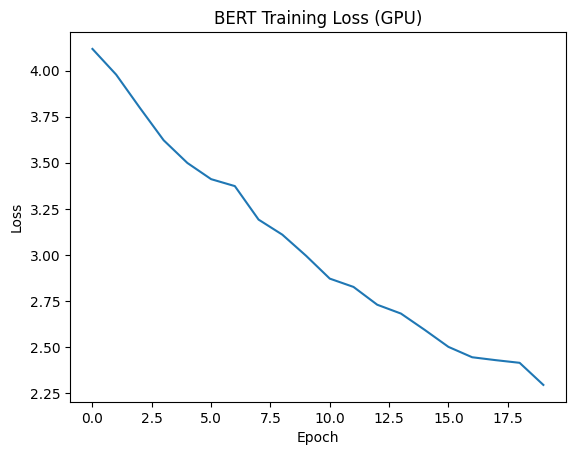

In [ ]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT Training Loss (GPU)")
plt.show()


In [ ]:
# topics = {
#     "nepal": [
#         "nepal is a beautiful country",
#         "nepal lies between india and china",
#         "nepal has rich cultural heritage",
#         "tourism is important for nepal economy"
#     ],
#     "ai": [
#         "artificial intelligence mimics human intelligence",
#         "machine learning learns from data",
#         "deep learning uses multiple layers",
#         "neural networks perform complex tasks"
#     ],
#     "nlp": [
#         "natural language processing analyzes text",
#         "language models predict word probabilities",
#         "bert uses bidirectional context",
#         "transformers rely on self attention"
#     ],
#     "education": [
#         "education empowers individuals",
#         "students develop critical thinking",
#         "learning improves knowledge",
#         "practice enhances performance"
#     ]
# }

# sentences = []
# for _ in range(250):
#     for topic in topics.values():
#         sentences.extend(topic)

# print("Total sentences:", len(sentences))


Total sentences: 4000


In [ ]:
# Special tokens
PAD, CLS, SEP, MASK = "[PAD]", "[CLS]", "[SEP]", "[MASK]"

def build_vocab(sentences):
    counter = Counter()
    for s in sentences:
        counter.update(s.split())

    vocab = {PAD:0, CLS:1, SEP:2, MASK:3}
    for word in counter:
        vocab[word] = len(vocab)

    inv_vocab = {v:k for k,v in vocab.items()}
    return vocab, inv_vocab

vocab, inv_vocab = build_vocab(sentences)
vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 21823


In [ ]:
MAX_LEN = 12

def encode(sentence):
    tokens = sentence.split()
    ids = [vocab[CLS]] + [vocab[t] for t in tokens] + [vocab[SEP]]
    ids += [vocab[PAD]] * (MAX_LEN - len(ids))
    return ids[:MAX_LEN]

encoded_data = torch.tensor([encode(s) for s in sentences])


In [ ]:
def mask_tokens(inputs):
    labels = inputs.clone()

    for i in range(inputs.size(0)):
        for j in range(inputs.size(1)):
            if inputs[i,j] in [vocab[PAD], vocab[CLS], vocab[SEP]]:
                labels[i,j] = -100
                continue

            if random.random() < 0.15:
                prob = random.random()
                if prob < 0.8:
                    inputs[i,j] = vocab[MASK]
                elif prob < 0.9:
                    inputs[i,j] = random.randint(4, vocab_size-1)
            else:
                labels[i,j] = -100

    return inputs, labels


In [ ]:
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embed_size)
        self.position = nn.Embedding(MAX_LEN, embed_size)
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x):
        pos = torch.arange(0, x.size(1)).unsqueeze(0)
        return self.norm(self.token(x) + self.position(pos))


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size*4),
            nn.GELU(),
            nn.Linear(embed_size*4, embed_size)
        )

    def forward(self, x):
        attn, _ = self.attn(x, x, x)
        x = self.norm1(x + attn)
        ff = self.ff(x)
        return self.norm2(x + ff)


In [ ]:
class BERT(nn.Module):
    def __init__(self, vocab_size, embed_size=64, layers=2, heads=2):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, embed_size)
        self.encoder = nn.ModuleList(
            [TransformerBlock(embed_size, heads) for _ in range(layers)]
        )
        self.mlm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1,0,2)  # seq, batch, embed
        for layer in self.encoder:
            x = layer(x)
        x = x.permute(1,0,2)
        return self.mlm_head(x)


In [ ]:
model = BERT(vocab_size)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []


In [ ]:
EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    inputs, labels = mask_tokens(encoded_data.clone())
    outputs = model(inputs)

    loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # validation (reuse data for demo)
    model.eval()
    with torch.no_grad():
        val_inputs, val_labels = mask_tokens(encoded_data.clone())
        val_outputs = model(val_inputs)
        val_loss = criterion(
            val_outputs.view(-1, vocab_size),
            val_labels.view(-1)
        )
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


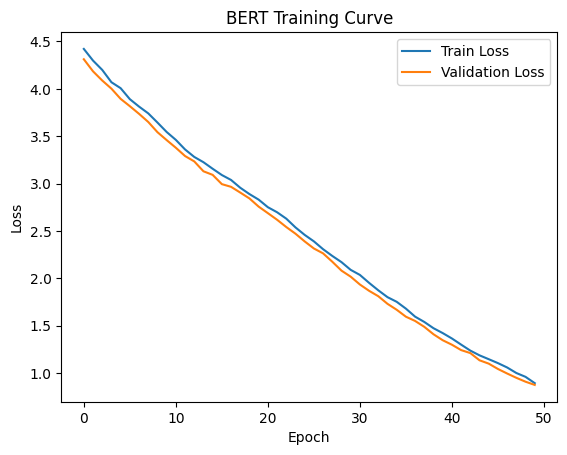

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT Training Curve")
plt.legend()
plt.show()


In [ ]:
def predict_mask(sentence):
    model.eval()
    ids = encode(sentence)
    x = torch.tensor([ids])

    with torch.no_grad():
        output = model(x)

    mask_idx = ids.index(vocab[MASK])
    probs = torch.softmax(output[0, mask_idx], dim=0)
    pred_id = torch.argmax(probs).item()
    return inv_vocab[pred_id]

# Example
test_sentence = "machine learning [MASK] from data"
print("Prediction:", predict_mask(test_sentence))


Prediction: learns
